🌳 1. Pruning in Decision Trees
Pruning simplifies the tree by removing sections that provide little power to classify instances. Types include:

a. Pre-Pruning (Early Stopping)
Stops tree growth before it perfectly fits the training data.

Common criteria:

Maximum tree depth

Minimum number of samples per node

Minimum information gain

b. Post-Pruning (Cost Complexity Pruning / Reduced Error Pruning)
Grow the full tree, then prune back.

Common methods:

Reduced Error Pruning: Prune nodes if it doesn't reduce validation accuracy.

Cost Complexity Pruning (used in CART): Introduces a complexity parameter α to balance size and accuracy.



In [1]:
# this lesson will involve post pruning cost complexity

In [2]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import data


In [3]:
df = pd.read_csv('processed.cleveland.data' , header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


| Variable Name | Role    | Type        | Demographic | Description                                                  | Units   | Missing Values |
|---------------|---------|-------------|-------------|--------------------------------------------------------------|---------|----------------|
| age           | Feature | Integer     | Age         |                                                              | years   | no             |
| sex           | Feature | Categorical | Sex         |                                                              |         | no             |
| cp            | Feature | Categorical |             |                                                              |         | no             |
| trestbps      | Feature | Integer     |             | resting blood pressure (on admission to the hospital)       | mm Hg   | no             |
| chol          | Feature | Integer     |             | serum cholestoral                                           | mg/dl   | no             |
| fbs           | Feature | Categorical |             | fasting blood sugar > 120 mg/dl                             |         | no             |
| restecg       | Feature | Categorical |             |                                                              |         | no             |
| thalach       | Feature | Integer     |             | maximum heart rate achieved                                 |         | no             |
| exang         | Feature | Categorical |             | exercise induced angina                                     |         | no             |
| oldpeak       | Feature | Integer     |             | ST depression induced by exercise relative to rest          |         | no             |
| slope         | Feature | Categorical |             |                                                              |         | no             |
| ca            | Feature | Integer     |             | number of major vessels (0-3) colored by fluoroscopy         |         | yes            |
| thal          | Feature | Categorical |             |                                                              |         | yes            |
| num           | Target  | Integer     |             | diagnosis of heart disease                                  |         | no             |


In [4]:
# change the column numbers to column names
# cp = chest pain ,
df.columns = ['age' , 'sex' , 'cp' , 'restbp' , 'chol' , 'fbs' , 'restecg' , 'thalach' , 'exang' , 'oldpeak' , 'slope' , 'ca' , 'thal' , 'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# MISSING DATA

In [5]:
# identifying missing data
df.dtypes

,0
age,float64
sex,float64
cp,float64
restbp,float64
chol,float64
fbs,float64
restecg,float64
thalach,float64
exang,float64
oldpeak,float64


In [6]:
df['ca'].unique()
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [7]:
# dealing with missing data
# 1. print rows with missing values
len(df.loc[df['ca'] == '?'])  + len(df.loc[df['thal'] == '?'])

6

In [8]:
df.loc[df['ca'] == '?']

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [9]:
df.loc[df['thal'] == '?']

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


In [10]:
len(df)

303

In [11]:
# remove rows
df_no_missing = df[(df['ca'] != '?') & (df['thal'] != '?')]

In [12]:
len(df_no_missing)

297

In [13]:
df_no_missing['ca'].unique()
df_no_missing['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

FORMAT DATA

In [14]:
X = df_no_missing.drop('hd' , axis = 1).copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [15]:
y = df_no_missing['hd'].copy()
y.head()

,hd
0,0
1,2
2,1
3,0
4,0


In [16]:
# one hot encoding using get_dummies (pandas)
# also column transformer can be used (scikit learn)


In [17]:
pd.get_dummies(X , columns = ['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,True,False,False,False
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,False,False,False,True
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False,False,True,False
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,False,True,False,False


In [18]:
X_encoded = pd.get_dummies(X , columns=['cp' , 'restecg' , 'slope' , 'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,False,True,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,True,False,False,True,False,True,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,True,False,False,True,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,False,True,False,False,False,False,True,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,False,True,True,False,False,True,False,False


In [19]:
# sex , fbs . exang - categorical columns

In [20]:
y.unique()

array([0, 2, 1, 3, 4])

In [21]:
# convert values greater than 0 to 1
y_not_zero_index = y > 0
y[y_not_zero_index] = 1
y.unique()

array([0, 1])

Build Preliminary Classification Tree

In [22]:
# split dataset into training and testing sets
X_train , X_test , y_train , y_test = train_test_split(X_encoded , y , random_state=42)

# create desc. tree and fit it to training data
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train , y_train)

[Text(0.5732758620689655, 0.9583333333333334, 'ca <= 0.5\ngini = 0.498\nsamples = 222\nvalue = [118, 104]\nclass = No Heart Disease'),
 Text(0.33189655172413796, 0.875, 'thal_7.0 <= 0.5\ngini = 0.382\nsamples = 132\nvalue = [98, 34]\nclass = No Heart Disease'),
 Text(0.4525862068965517, 0.9166666666666667, 'True  '),
 Text(0.2025862068965517, 0.7916666666666666, 'oldpeak <= 2.7\ngini = 0.24\nsamples = 93\nvalue = [80.0, 13.0]\nclass = No Heart Disease'),
 Text(0.14655172413793102, 0.7083333333333334, 'age <= 58.5\ngini = 0.185\nsamples = 87\nvalue = [78, 9]\nclass = No Heart Disease'),
 Text(0.08620689655172414, 0.625, 'chol <= 311.5\ngini = 0.061\nsamples = 63\nvalue = [61, 2]\nclass = No Heart Disease'),
 Text(0.05172413793103448, 0.5416666666666666, 'restbp <= 109.0\ngini = 0.033\nsamples = 60\nvalue = [59, 1]\nclass = No Heart Disease'),
 Text(0.034482758620689655, 0.4583333333333333, 'sex <= 0.5\ngini = 0.278\nsamples = 6\nvalue = [5, 1]\nclass = No Heart Disease'),
 Text(0.017241

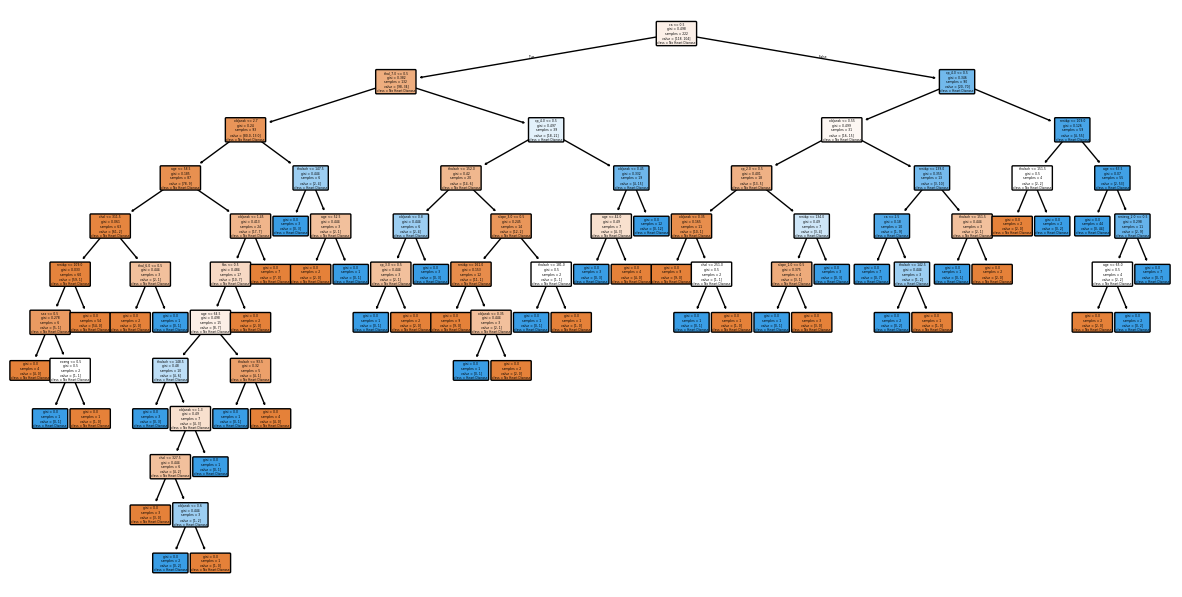

In [23]:
# plot tree
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt , filled=True , rounded = True , class_names = ['No Heart Disease' , 'Heart Disease'] , feature_names=X_encoded.columns)

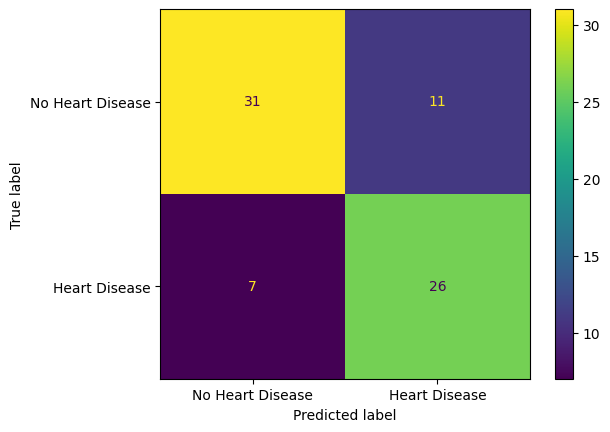

In [24]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Heart Disease', 'Heart Disease'])
disp.plot()
plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['No Heart Disease', 'Heart Disease']))

                  precision    recall  f1-score   support

No Heart Disease       0.82      0.74      0.78        42
   Heart Disease       0.70      0.79      0.74        33

        accuracy                           0.76        75
       macro avg       0.76      0.76      0.76        75
    weighted avg       0.77      0.76      0.76        75



In [26]:
# recall - percentage of actual positives that were correctly predicted as positive.
# # the desicion tree has overfit the training dataset as for test recall is 74 and 79 % for non hd and hd respectively

pruning

In [27]:
# determine alpha values
path = clf_dt.cost_complexity_pruning_path(X_train , y_train)

ccp_alphas = path.ccp_alphas

# exclude max val of alpha
ccp_alphas = ccp_alphas[:-1]

clf_dts = [] # array in which we will put desc. trees

# create oone desc tree per value for allpha and store in array
for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state = 0 , ccp_alpha = ccp_alpha)
  clf_dt.fit(X_train , y_train)
  clf_dts.append(clf_dt)

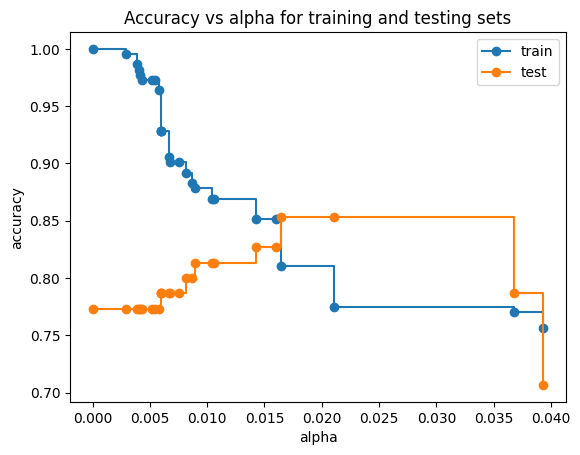

In [28]:
train_scores = [clf_dt.score(X_train , y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test , y_test) for clf_dt in clf_dts]

fig , ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alpha for training and testing sets')
ax.plot(ccp_alphas , train_scores , marker = 'o' , label = 'train' , drawstyle = 'steps-post')
ax.plot(ccp_alphas , test_scores , marker = 'o' , label = 'test' , drawstyle = 'steps-post')
ax.legend()
plt.show()

Cross Validation

<Axes: xlabel='tree'>

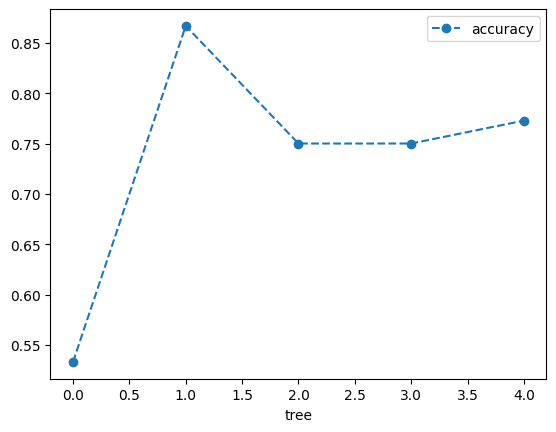

In [29]:
clf_dt = DecisionTreeClassifier(random_state = 42 , ccp_alpha = 0.016)

# 5 fold cross validation to create 5 diff training and tesing datasets used to train and test tree
# we use 5 fold as we have less data

scores = cross_val_score(clf_dt , X_train , y_train , cv = 5)
df = pd.DataFrame(data = {'tree' : range(5) , 'accuracy' : scores})
df.plot(x='tree' , y='accuracy' , marker='o' , linestyle='--')

<Axes: xlabel='alpha'>

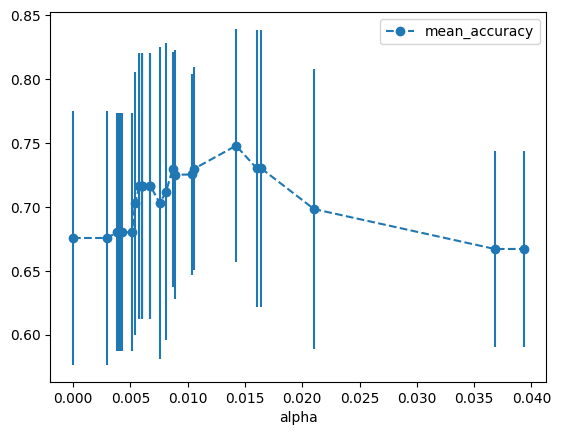

In [32]:
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state = 0 , ccp_alpha = ccp_alpha)
  scores = cross_val_score(clf_dt , X_train , y_train , cv = 5)
  alpha_loop_values.append([ccp_alpha , np.mean(scores) , np.std(scores)])

alpha_results = pd.DataFrame(data = alpha_loop_values , columns = ['alpha' , 'mean_accuracy' , 'std'])
alpha_results.plot(x='alpha' , y='mean_accuracy' , yerr = 'std' , marker= 'o' , linestyle = '--')

In [34]:
alpha_results[(alpha_results['alpha'] > 0.014) & (alpha_results['alpha'] < 0.015)]

,alpha,mean_accuracy,std
20,0.014225,0.747778,0.091395


In [38]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.014) & (alpha_results['alpha'] < 0.015)]['alpha']
ideal_ccp_alpha

,alpha
20,0.014225


final tree

In [42]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42 , ccp_alpha = ideal_ccp_alpha.iloc[0])
clf_dt_pruned.fit(X_train , y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(0.014224751066856332),
                       random_state=42)

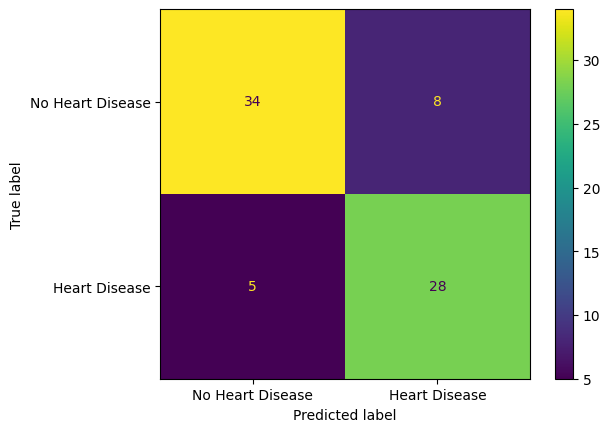

In [43]:
# plot confusion matrix for the pruned tree
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_pruned = clf_dt_pruned.predict(X_test)
cm_pruned = confusion_matrix(y_test, y_pred_pruned, labels=clf_dt_pruned.classes_)
disp_pruned = ConfusionMatrixDisplay(confusion_matrix=cm_pruned, display_labels=['No Heart Disease', 'Heart Disease'])
disp_pruned.plot()
plt.show()

[Text(0.5769230769230769, 0.875, 'ca <= 0.5\ngini = 0.498\nsamples = 222\nvalue = [118, 104]\nclass = No Heart Disease'),
 Text(0.3076923076923077, 0.625, 'thal_7.0 <= 0.5\ngini = 0.382\nsamples = 132\nvalue = [98, 34]\nclass = No Heart Disease'),
 Text(0.4423076923076923, 0.75, 'True  '),
 Text(0.15384615384615385, 0.375, 'oldpeak <= 2.7\ngini = 0.24\nsamples = 93\nvalue = [80.0, 13.0]\nclass = No Heart Disease'),
 Text(0.07692307692307693, 0.125, 'gini = 0.185\nsamples = 87\nvalue = [78, 9]\nclass = No Heart Disease'),
 Text(0.23076923076923078, 0.125, 'gini = 0.444\nsamples = 6\nvalue = [2, 4]\nclass = Heart Disease'),
 Text(0.46153846153846156, 0.375, 'cp_4.0 <= 0.5\ngini = 0.497\nsamples = 39\nvalue = [18, 21]\nclass = Heart Disease'),
 Text(0.38461538461538464, 0.125, 'gini = 0.42\nsamples = 20\nvalue = [14, 6]\nclass = No Heart Disease'),
 Text(0.5384615384615384, 0.125, 'gini = 0.332\nsamples = 19\nvalue = [4, 15]\nclass = Heart Disease'),
 Text(0.8461538461538461, 0.625, 'cp_4

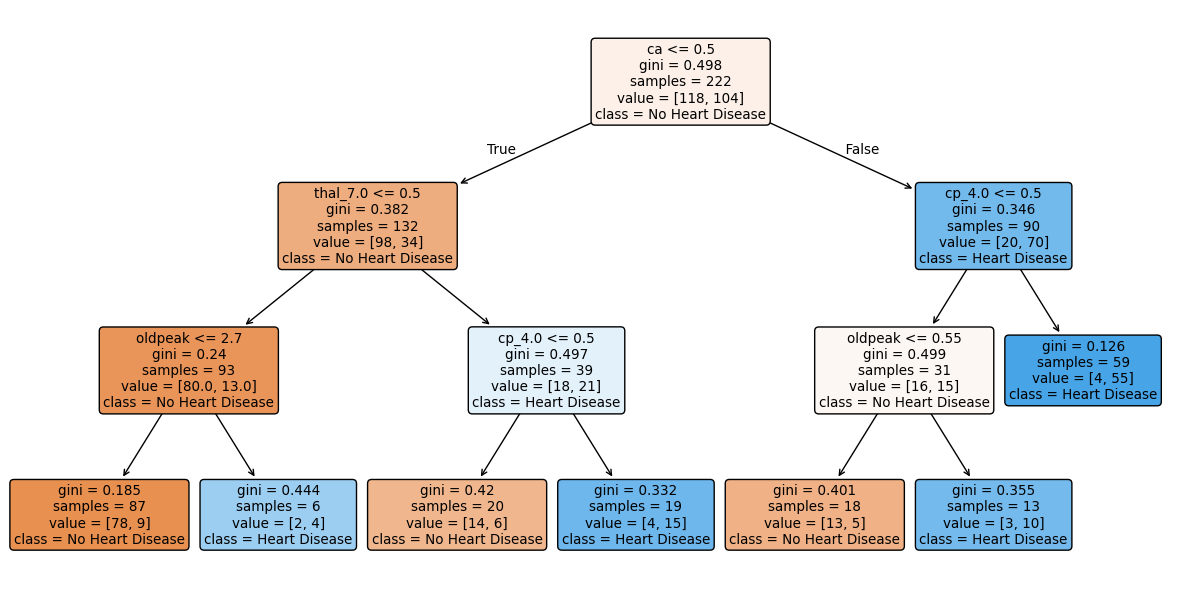

In [45]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned , filled=True , rounded = True , class_names = ['No Heart Disease' , 'Heart Disease'] , feature_names=X_encoded.columns)